# Chainer で 犬、猫の分類に挑戦する！
https://qiita.com/Naritoshi/items/20277141a39ff32cd6ae

In [3]:
import chainer
#import cupy
chainer.print_runtime_info()
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

Chainer: 4.2.0
NumPy: 1.15.0
CuPy: Not Available
GPU availability: False
cuDNN availablility: False


## 犬、猫のデータを取得、解凍する

In [4]:
import os
import requests
import zipfile

file_name = "dogscats.zip"
url='http://files.fast.ai/data/dogscats.zip'
response = requests.get(url)
with open(os.path.join("./", file_name), 'wb') as f:
    f.write(response.content)

In [12]:
!python -m zipfile -e dogscats.zip ./

## データを、Chainerで利用可能な形に成型する
- 画像サイズを統一する
- shapeを「チャンネル，縦，横」にする（ChainerでCNNを利用する場合、左記のようなshapeにする必要がある）
- TransformDataset型にする

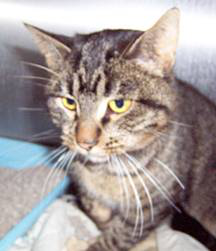

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
img_path = './dogscats/train/cats/cat.9021.jpg'
Image.open(img_path)

In [16]:
def img_resize(img, out_size, is_file_path=True):
  if (is_file_path):
    img = Image.open(img)
  else:
    #Chainerの「チャネル、縦、横」→「縦、横、チャネル」にする
    #後で、TransformDatasetを作ると気にこちらを使います
    #※image_dataset.pyの中で、transpose(2, 0, 1)をしてくれているので、
    #  リサイズするなら、transpose(1, 2, 0)が必要なようです
    img = Image.fromarray(img.transpose(1, 2, 0))

  resized_img = img.resize(out_size, Image.BICUBIC)

  return resized_img

<PIL.Image.Image image mode=RGB size=120x120 at 0x1B9508C5E10>


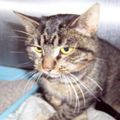

In [17]:
resized_img = img_resize('./dogscats/train/cats/cat.9021.jpg', (120, 120))
print(resized_img)
resized_img

In [18]:
#ndarray型に変換(縦、横がわかりやすいように、サイズを変えてます)
resized_img = img_resize('./dogscats/train/cats/cat.9021.jpg', (120, 200))
img_array = np.array(resized_img)

#shapeを確認する
img_array.shape

(200, 120, 3)

In [19]:
#shapeを「チャンネル，縦，横」にする
def img_to_chainer_shape(img):
  img_array = np.array(img)
  return img_array.transpose(2, 0, 1)

In [20]:
#変わっていることを確認する
img = np.array(img_to_chainer_shape(img_resize('./dogscats/train/cats/cat.9021.jpg', (120, 200))))
img.shape

(3, 200, 120)

### TransformDataset型にする
メモリに展開しないで、データセットを作ります。
https://qiita.com/mitmul/items/5502ecdd2f0b444c427f

In [21]:
from chainer import datasets
cats_train_path = 'dogscats/train/cats/'
dogs_train_path = 'dogscats/train/dogs/'
cats_valid_path = 'dogscats/valid/cats/'
dogs_valid_path = 'dogscats/valid/dogs/'

In [22]:
filepath_and_label_list = []

In [23]:
import os

def get_image_filepath_list(dir, label):
  filepath_list = []
  files = os.listdir(dir)
  for file in files:
    filepath_list.append((dir + file, label))
  return filepath_list

In [24]:
#学習と検証データを一緒にしてます
filepath_and_label_list.extend(get_image_filepath_list(cats_train_path, 0))
filepath_and_label_list.extend(get_image_filepath_list(dogs_train_path, 1))
filepath_and_label_list.extend(get_image_filepath_list(cats_valid_path, 0))
filepath_and_label_list.extend(get_image_filepath_list(dogs_valid_path, 1))

In [25]:
# 各データに行う変換
def transform(inputs):
  img , label = inputs
  #サイズ変換
  img = img_resize(img.astype(np.uint8), (120, 120), False)
  #Chainer用のChapeにする
  img = img_to_chainer_shape(img)
  #スケーリング(データを0～1の間にする)
  img = img.astype(np.float32) / 255
  # ランダムに左右反転
  if np.random.rand() > 0.5:
      img = img[..., ::-1]
  return img, label

In [28]:
from chainer.datasets import LabeledImageDataset

# データセット作成
d = LabeledImageDataset(filepath_and_label_list)

ImportError: PIL cannot be loaded. Install Pillow!
The actual import error is as follows:
No module named 'PIL'

In [29]:
from chainer.datasets import TransformDataset
#変換をメソッドを設定する
td = TransformDataset(d, transform)

NameError: name 'd' is not defined

## 学習する

### データセットを学習、検証で分ける

In [30]:
from chainer import datasets

train, valid = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

NameError: name 'td' is not defined

### モデルを定義する
https://qiita.com/mitmul/items/1e35fba085eb07a92560

In [31]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training,serializers,Chain,datasets,sequential,optimizers,iterators
from chainer.training import extensions,Trainer
from chainer.dataset import concat_examples

In [32]:
class CNN(Chain):
  def __init__(self):
    super(CNN, self).__init__()

    with self.init_scope():
      self.conv1 = L.Convolution2D(None, out_channels=32, ksize=3, stride=1, pad=1)
      self.conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=1, pad=1)
      self.conv3 = L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=1, pad=1)
      self.conv4 = L.Convolution2D(in_channels=128, out_channels=256, ksize=3, stride=1, pad=1)
      self.l1 = L.Linear(None, 1000)
      self.l2 = L.Linear(1000, 2)

  def __call__(self, x):
    f = F.max_pooling_2d(F.relu(self.conv1(x)), ksize=2, stride=2)
    f = F.max_pooling_2d(F.relu(self.conv2(f)), ksize=2, stride=2)
    f = F.max_pooling_2d(F.relu(self.conv3(f)), ksize=2, stride=2)
    f = F.max_pooling_2d(F.relu(self.conv4(f)), ksize=2, stride=2)
    f = F.dropout(F.relu(self.l1(f)), ratio=0.75)
    f = self.l2(f)
    return f

In [33]:
batchsize = 32
max_epoch = 10
gpu_id = 0

In [24]:
model = L.Classifier(CNN())
model.to_gpu(gpu_id)

In [0]:
train_iter = iterators.MultiprocessIterator(train, batchsize)
valid_iter = iterators.MultiprocessIterator(valid, batchsize, False, False)

In [0]:
optimaizer = optimizers.Adam().setup(model)
updater = training.StandardUpdater(train_iter, optimaizer, device=gpu_id)
trainer = Trainer(updater, stop_trigger=(max_epoch, 'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.dump_graph('main/loss'))

### 学習スタート！

In [27]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
     total [..................................................]  1.60%
this epoch [########..........................................] 16.00%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  3.20%
this epoch [################..................................] 32.00%
       200 iter, 0 epoch / 10 epochs
    5.7839 iters/sec. Estimated time to finish: 0:17:26.009240.
     total [##................................................]  4.80%
this epoch [########################..........................] 48.00%
       300 iter, 0 epoch / 10 epochs
    5.8378 iters/sec. Estimated time to finish: 0:16:59.221516.
     total [###...............................................]  6.40%
this epoch [################################..................] 64.00%
       400 iter, 0 epoch / 10 epochs
    5.8488 it

8           0.214604    0.91325        0.346436       0.855096           1126.64       
     total [########################################..........] 80.00%
this epoch [..................................................]  0.00%
      5000 iter, 8 epoch / 10 epochs
    4.4627 iters/sec. Estimated time to finish: 0:04:40.101318.
     total [########################################..........] 81.60%
this epoch [########..........................................] 16.00%
      5100 iter, 8 epoch / 10 epochs
    4.4542 iters/sec. Estimated time to finish: 0:04:18.183123.
     total [#########################################.........] 83.20%
this epoch [################..................................] 32.00%
      5200 iter, 8 epoch / 10 epochs
    4.4754 iters/sec. Estimated time to finish: 0:03:54.617103.
     total [##########################################........] 84.80%
this epoch [########################..........................] 48.00%
      5300 iter, 8 epoch / 10 epochs
    

### 学習結果を確認する

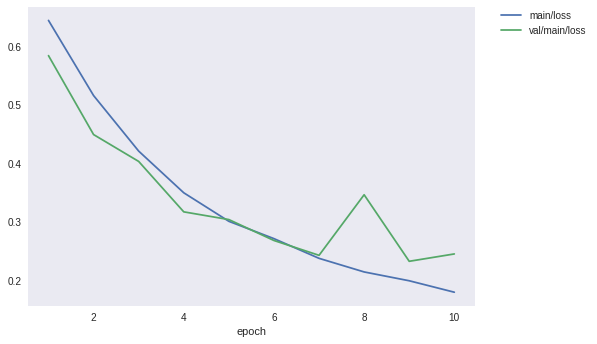

In [28]:
Image.open('result/loss.png')

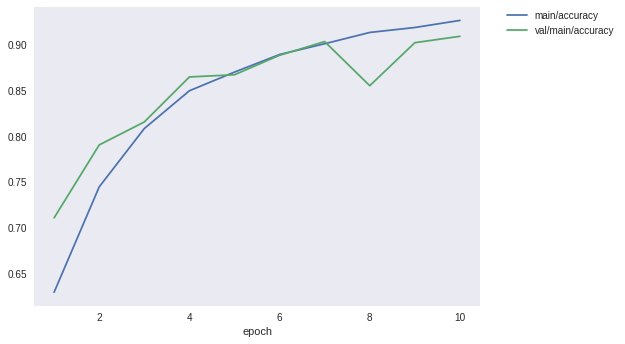

In [29]:
Image.open('result/accuracy.png')

## 検証する

### 学習済みモデルを読み込む

In [30]:
#保存するフォルダを確認する
%%bash
ls

datalab
dogscats
dogscats.zip
result


In [31]:
#resultの中に、snapshotができているので、確認する
%%bash
ls result

accuracy.png
cg.dot
log
loss.png
snapshot_epoch-1
snapshot_epoch-10
snapshot_epoch-2
snapshot_epoch-3
snapshot_epoch-4
snapshot_epoch-5
snapshot_epoch-6
snapshot_epoch-7
snapshot_epoch-8
snapshot_epoch-9


In [50]:
model = L.Classifier(CNN())

infer_net = model
#serializers.load_npz('snapshot_epoch-' + str(max_epoch), infer_net, path='updater/model:main/')
serializers.load_npz('result/snapshot_epoch-' + str(max_epoch), infer_net, path='updater/model:main/')

infer_net.to_gpu(0)

### テストデータで検証する

In [0]:
def get_x_test(file_path, size, show=True):
  if show:
    plt.imshow(Image.open(file_path))
  #リサイズ
  x = img_resize(file_path, size, True)
  #リシェイプ
  x = img_to_chainer_shape(x)
  #型変換
  #float32にする
  x = x.astype(np.float32)
  # ネットワークと同じデバイス上にデータを送る
  x = infer_net.xp.asarray(x)
  #[ミニバッチ、チャネル、高さ、幅]にする
  x = x[None, ...]
  return x

In [67]:
import glob
flist = glob.glob("dogscats/test1/*.jpg")
print(len(flist),flist)

12500 ['dogscats/test1/2893.jpg', 'dogscats/test1/12210.jpg', 'dogscats/test1/7217.jpg', 'dogscats/test1/7768.jpg', 'dogscats/test1/6043.jpg', 'dogscats/test1/3338.jpg', 'dogscats/test1/11245.jpg', 'dogscats/test1/3775.jpg', 'dogscats/test1/2646.jpg', 'dogscats/test1/998.jpg', 'dogscats/test1/7514.jpg', 'dogscats/test1/7358.jpg', 'dogscats/test1/1510.jpg', 'dogscats/test1/8119.jpg', 'dogscats/test1/10876.jpg', 'dogscats/test1/1082.jpg', 'dogscats/test1/11299.jpg', 'dogscats/test1/8192.jpg', 'dogscats/test1/6637.jpg', 'dogscats/test1/8198.jpg', 'dogscats/test1/5681.jpg', 'dogscats/test1/7811.jpg', 'dogscats/test1/9157.jpg', 'dogscats/test1/1207.jpg', 'dogscats/test1/2505.jpg', 'dogscats/test1/2990.jpg', 'dogscats/test1/7237.jpg', 'dogscats/test1/11982.jpg', 'dogscats/test1/8316.jpg', 'dogscats/test1/10713.jpg', 'dogscats/test1/10226.jpg', 'dogscats/test1/10213.jpg', 'dogscats/test1/424.jpg', 'dogscats/test1/9352.jpg', 'dogscats/test1/1428.jpg', 'dogscats/test1/3923.jpg', 'dogscats/test1

dogscats/test1/6155.jpg
[[-489.02277  491.48965]]
1
予測ラベル: 犬


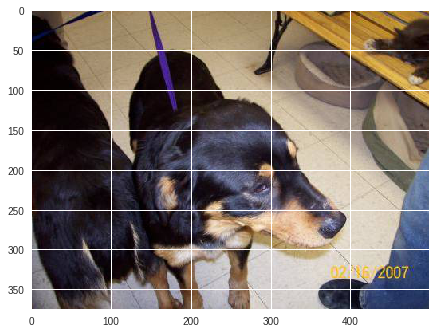

In [84]:
import random
TEST_FNAME = random.choice(flist)
print(TEST_FNAME)

from chainer.cuda import to_cpu

#x_test = get_x_test('dogscats/test1/5011.jpg', (120, 120))
x_test = get_x_test(TEST_FNAME, (120, 120))

with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net.predictor(x_test)

y = to_cpu(y.array)

print(y)

y = y.argmax(axis=1)[0]

print(y)

if y == 0:
  y = '猫'
else:
  y = '犬'

print('予測ラベル:', y)